In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

2024-08-05 12:43:44.993628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 12:43:45.967763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Benign Images


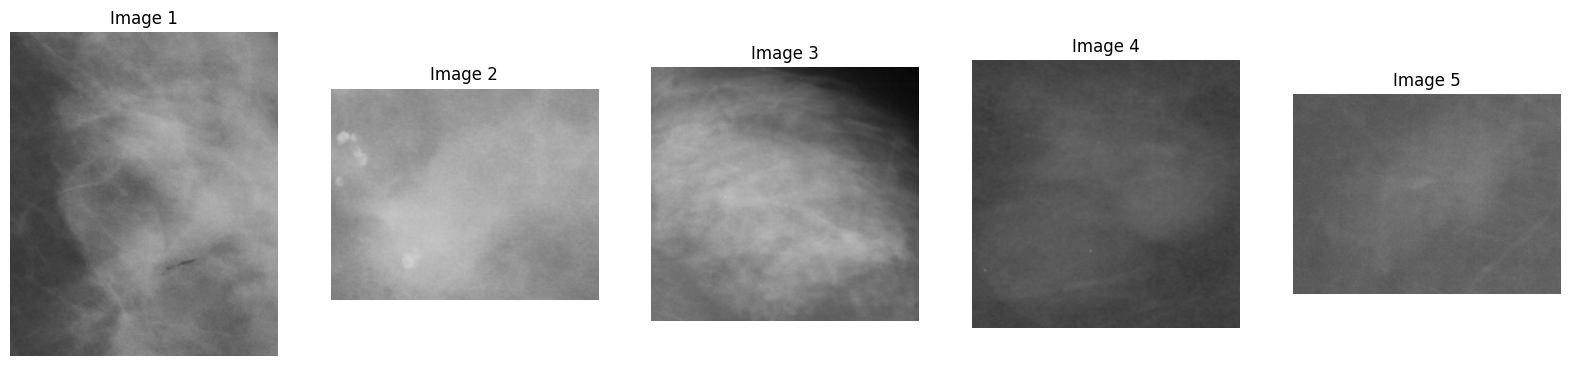

Malignant Images


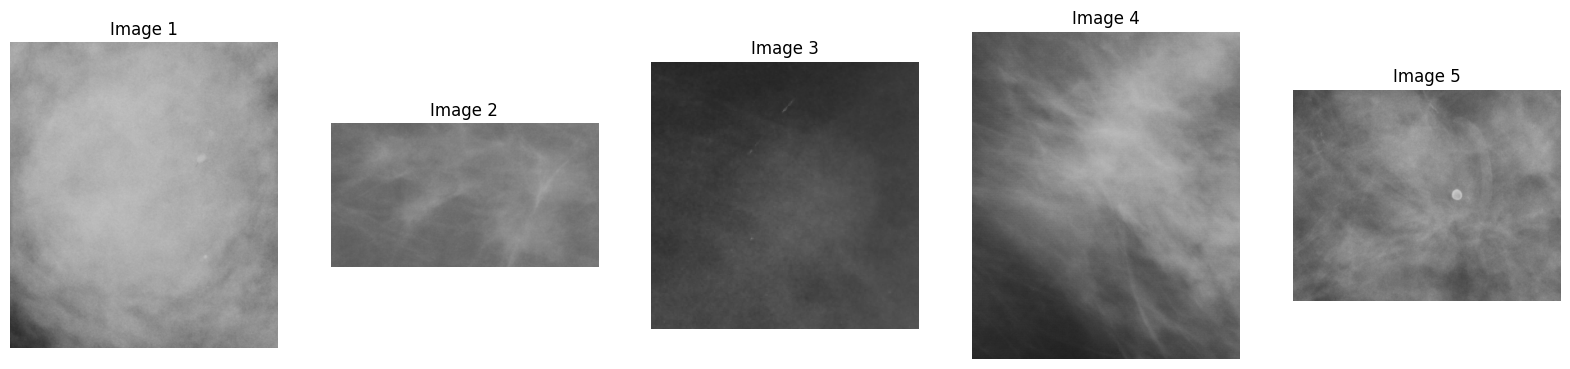

In [2]:

# Define paths
base_dir = '/home/ubuntu/BSC/Breast_Cancer_Segmentation/Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Function to load and display images using cv2
def load_and_display_images(folder_path, num_images=5):
    images = []
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.png'):
                img_path = os.path.join(subdir, file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                images.append(img)
                if len(images) >= num_images:
                    break
        if len(images) >= num_images:
            break
    
    # Display images
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.show()

# Visualize Benign and Malignant Images from Training Set
benign_folder = os.path.join(train_dir, 'benign')
malignant_folder = os.path.join(train_dir, 'malignant')

print("Benign Images")
load_and_display_images(benign_folder)

print("Malignant Images")
load_and_display_images(malignant_folder)

In [3]:
# Create ImageDataGenerators for augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and augment the data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(256, 256), batch_size=32, class_mode=None)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(256, 256), batch_size=32, class_mode=None)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(256, 256), batch_size=32, class_mode=None)

Found 1370 images belonging to 2 classes.
Found 198 images belonging to 2 classes.
Found 393 images belonging to 2 classes.


In [5]:
class AutoencoderDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_generator, batch_size):
        self.image_generator = image_generator
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_generator)

    def __getitem__(self, index):
        batch_x = self.image_generator[index]
        return batch_x, batch_x

# Create the custom data generators
train_autoencoder_generator = AutoencoderDataGenerator(train_generator, batch_size=32)
validation_autoencoder_generator = AutoencoderDataGenerator(validation_generator, batch_size=32)
test_autoencoder_generator = AutoencoderDataGenerator(test_generator, batch_size=32)

def unet_autoencoder(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = layers.Dropout(0.5)(pool1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = layers.Dropout(0.5)(pool2)

    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = layers.Dropout(0.5)(pool3)

    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = layers.Dropout(0.5)(pool4)

    # Bottleneck
    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(pool4)
    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv5)
    conv5 = layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = layers.Conv2D(256, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge6)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv6)

    up7 = layers.Conv2D(128, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge7)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv7)

    up8 = layers.Conv2D(64, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge8)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv8)

    up9 = layers.Conv2D(32, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv9)
    conv10 = layers.Conv2D(3, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

autoencoder = unet_autoencoder()
autoencoder.summary()

2024-08-05 12:54:55.507470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 5.81MiB (6094848 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-08-05 12:54:55.508822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 5.81MiB (6094848 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


2024-08-05 12:55:05.510289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 5.81MiB (6094848 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-08-05 12:55:05.511582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 5.81MiB (6094848 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-08-05 12:55:05.511634: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25MiB (rounded to 2359296)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-08-05 12:55:05.511650: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-08-05 12:55:05.511659: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 36, Chunks i

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2]